### Regression analysis of life expectancy in various countries.

Predicting the life expectancy in a given country using [Gapminder data](https://www.gapminder.org/data/).

In [2]:
# Import numpy and pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


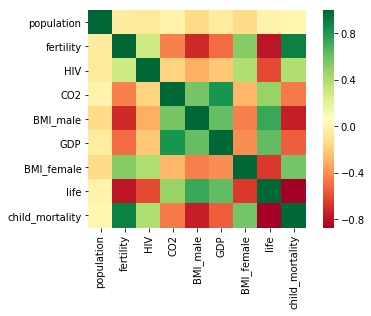

In [3]:
# Read the CSV file into a DataFrame
df = pd.read_csv('datasets/gapminder_2008_region.csv')

# Explore the correlation between different features in the datatset.
sns.heatmap(df.corr(), square=True, cmap='RdYlGn')

In [4]:
# I'll first try fitting a linear regression with just one feature: 'fertility'

# Create arrays for features and target variable
y = df['life'].values
X = df['fertility'].values

# Print the dimensions of X and y before reshaping
print("Dimensions of y before reshaping: {}".format(y.shape))
print("Dimensions of X before reshaping: {}".format(X.shape))

Dimensions of y before reshaping: (139,)
Dimensions of X before reshaping: (139,)


In [5]:
# I'll make use of reshaping using NumPy's .reshape() method due to there being only 1 feature. 

# Reshape X and y
y = y.reshape(-1,1)
X_fertility = X.reshape(-1,1)

# Print the dimensions of X and y after reshaping
print("Dimensions of y after reshaping: {}".format(y.shape))
print("Dimensions of X after reshaping: {}".format(X.shape))

Dimensions of y after reshaping: (139, 1)
Dimensions of X after reshaping: (139,)


In [6]:
# Create the regressor
reg = LinearRegression()

# Create the prediction space
prediction_space = np.linspace(min(X_fertility), max(X_fertility)).reshape(-1,1)

# Fitting the model to the data
reg.fit(X_fertility, y)

# Compute predictions over the prediction space: y_pred
y_pred = reg.predict(prediction_space)

# Print R^2 
print(reg.score(X_fertility, y))

0.6192442167740035


#### R-squared score
`0.62` isn't a great R-squared score, but that is to be expected given I'm only using 1 feature to make the prediction. That said, you can see below that life expectancy and fertility are clearly negatively correlated, and our line of best fit does make and attempt to estimate that correlation. Nonetheless, to better understand R-squared it helps to know that it's the proportion of the variance in the dependent variable that is predictable from the independent variable.

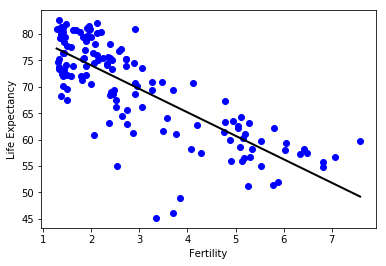

In [7]:
# Plot regression line against fertility vs life expectancy
plt.scatter(X_fertility, y, color='blue')
plt.plot(prediction_space, y_pred, color='black', linewidth=2)
plt.xlabel('Fertility')
plt.ylabel('Life Expectancy')
plt.show()

In [8]:
#review all columns for any potential non-numeric features
df.columns

Index([u'population', u'fertility', u'HIV', u'CO2', u'BMI_male', u'GDP',
       u'BMI_female', u'life', u'child_mortality', u'Region'],
      dtype='object')

#### Fitting a linear regressor
To make sure the model generalizes well to unseen data I'll make use of `train_test_split` to create a holdout set of data for evaluation. I'll fit the training set and predict a linear regression over all the numeric features in the unseen test set. R-squared and the root mean squared error will be used to evalutate the model's performance.

In [9]:
# Now I'll do similiarly with train test split over all numeric values in the dataset.
df_all_features = pd.read_csv('datasets/gapminder_2008_region.csv')
df_columns_numeric = df_all_features.drop(['life', 'Region'], axis=1)

y = df_all_features['life'].values
X = df_columns_numeric.values

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.838046873143
Root Mean Squared Error: 3.24760108004


#### R-squared and RMSE
The default scoring method for LinearRegression is R-squared. R-squared quantifies the amount of variance in the target variable that is predicated from the feature variables--between 0 and 1. More simply, R-squared is the fraction by which the variance of the errors is less than the variance of the dependent variable. Here, R-squared is `0.838` while the mean squared error of `3.247` gives the average of the squares of the errors—that is, the average squared difference between the estimated values and what is estimated.

Now I'll continue to evaluate the efficacy of the model using cross validation in sklearn. Specifically, I'll see what difference 5 fold cross-validation makes versus 3 fold and 10 fold–-generally speaking the higher the cross-validation number is the more compuationally expensive your model will become.

In [10]:
# Compute 5-fold cross-validation scores
cv_scores = cross_val_score(reg, X, y, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

# Take the average of the five scores
print("Average 5 Fold cross-val score: {}".format(np.mean(cv_scores)))

[0.81720569 0.82917058 0.90214134 0.80633989 0.94495637]
Average 5 Fold cross-val score: 0.859962772279


In [11]:
# Let's see how 3 fold and 10 fold cross-validation compares to the 5 fold I already computed.

# Perform 3-fold CV
cvscores_3 = cross_val_score(reg, X, y, cv=3)
print("Average 3 fold cross-val: {}".format(np.mean(cvscores_3)))

# Perform 10-fold CV
cvscores_10 = cross_val_score(reg, X, y, cv=10)
print("Average 10 fold cross val: {}".format(np.mean(cvscores_10)))

Average 3 fold cross-val: 0.871871278262
Average 10 fold cross val: 0.843612862013


#### Regularization with Ridge and Lasso
Least Absolute Shrinkage and Selection Operator or Lasso adds 'absolute value of magnitude' of coefficient as penalty term to the loss function. While Ridge adds 'squared magnitude' of coefficient as penalty term to the loss function.

Since feature selection can be tricky I'll try to determine which feature(s) are most important using Lasso, and we'll see what effect it has.

[-0.         -0.         -0.          0.          0.          0.
 -0.         -0.07087587]


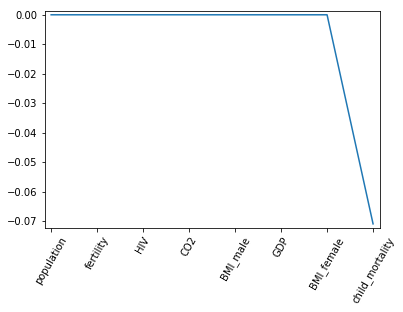

In [12]:
# Create a Pandas indexes object ussing the columns of interest dataframe 
df_columns = df_columns_numeric.columns

# Instantiate a lasso regressor
lasso = Lasso(alpha=0.4, normalize=True)

# Fit the regressor to the data
lasso.fit(X, y)

# Compute and print the coefficients
lasso_coef = lasso.coef_
print(lasso_coef)

# Plot the coefficients
plt.plot(range(len(df_columns)), lasso_coef)
plt.xticks(range(len(df_columns)), df_columns.values, rotation=60)
plt.margins(0.02)
plt.show()

### Lasso reduces unimportant features to zero. 
The plot shows that `child_mortality` has the strongest (negative) correlation with life expectancy while the rest of the features hover at 0. Lasso is great for feature selection, but when building regression models Ridge regression is more ideal. 

Next I'll practice practice fitting ridge regression models over a range of different alphas, and plot cross-validated R-squared scores for each, using the below function, which plots the R2 score as well as standard error for each alpha:

In [13]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

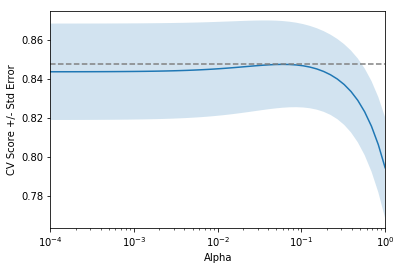

In [14]:
# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []

# Create a ridge regressor
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)


#### Hyperparameter tuning
Lasso uses the L1 penalty to regularize, while Ridge uses the L2 penalty. I'll make use an `ElasticNet` model where the penalty term is a linear combination of the L1 and L2 penalties. In scikit-learn, this term is represented by the 'l1_ratio' parameter: An 'l1_ratio' of 1 corresponds to an L1 penalty, and anything lower is a combination of L1 and  L2.

In [15]:
# Import the neccessary modules
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate an ElasticNet regressor
elastic_net = ElasticNet(tol=.1)

# Setup the GridSearchCV object
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_train, y_train)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet l1 ratio: {'l1_ratio': 0.3103448275862069}
Tuned ElasticNet R squared: 0.843944856741
Tuned ElasticNet MSE: 10.1628169582


#### Categorical variables
The rest of the features we've explored so far have all been numeric. Thankfully Pandas gives us an easy way to work with categorical data using `pd.get_dummies()`. Scikit Learn doesn't accept non-numeric data, so we use `pd.get_dummies()` to binarize categorical data (think 1s and 0s). I have yet to incorporate the 'Region' feature into this analysis, so let's try that now starting with a little EDA.

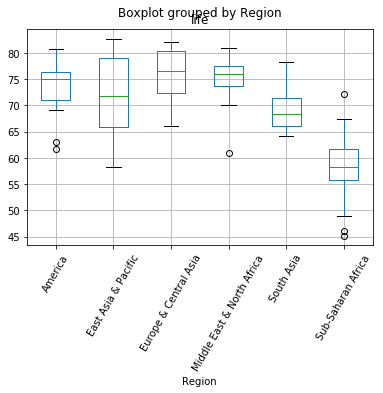

In [16]:
# Read 'gapminder.csv' into a DataFrame
df = pd.read_csv('datasets/gapminder_2008_region.csv')

# Create a boxplot of life expectancy per region
df.boxplot('life', 'Region', rot=60)

# Show the plot
plt.show()

In [17]:
# Create dummy variables
df_region = pd.get_dummies(df)

# Print the columns of df_region
print(df_region.columns)

# Create dummy variables with drop_first=True since the value can be implied 'Region_America'.
df_region = pd.get_dummies(df, drop_first=True)

# Print the new columns of df_region
print(df_region.columns)

Index([u'population', u'fertility', u'HIV', u'CO2', u'BMI_male', u'GDP',
       u'BMI_female', u'life', u'child_mortality', u'Region_America',
       u'Region_East Asia & Pacific', u'Region_Europe & Central Asia',
       u'Region_Middle East & North Africa', u'Region_South Asia',
       u'Region_Sub-Saharan Africa'],
      dtype='object')
Index([u'population', u'fertility', u'HIV', u'CO2', u'BMI_male', u'GDP',
       u'BMI_female', u'life', u'child_mortality',
       u'Region_East Asia & Pacific', u'Region_Europe & Central Asia',
       u'Region_Middle East & North Africa', u'Region_South Asia',
       u'Region_Sub-Saharan Africa'],
      dtype='object')


#### Transformed categoricals
Calling `pd.get_dummies()` on a dataframe transforms all categorical data into individual columns where the value 1 signifies an entry is in the group and 0 means it's not observed in the group. below we can see that the first entry in the data frame is an observation from `Region_Middle East & North Africa` region, which is signified by `1`:

In [18]:
print(df_region.head(1))

   population  fertility  HIV       CO2  BMI_male      GDP  BMI_female  life  \
0  34811059.0       2.73  0.1  3.328945   24.5962  12314.0    129.9049  75.3   

   child_mortality  Region_East Asia & Pacific  Region_Europe & Central Asia  \
0             29.5                           0                             0   

   Region_Middle East & North Africa  Region_South Asia  \
0                                  1                  0   

   Region_Sub-Saharan Africa  
0                          0  


#### Building the Ridge regression
Now I can build a regression models as I have before, but with 'Region' included. Next, I'll use ridge regression to perform 5-fold cross-validation.

In [19]:
# Instantiate a ridge regressor
ridge = Ridge(alpha=0.5, normalize=True)

# Create arrays for features and target variable
y = df_region['life'].values
X = df_region.drop('life', axis=1).values

# Perform 5-fold cross-validation
ridge_cv = cross_val_score(ridge, X, y, cv=5)

# Print the cross-validated scores
print(ridge_cv)
print("Average 5 Fold cross-val score: {}".format(np.mean(cv_scores)))

[0.86808336 0.80623545 0.84004203 0.7754344  0.87503712]
Average 5 Fold cross-val score: 0.859962772279


In [20]:
# Do a quick check to make sure we have no missing data in the data.
print(df_region.isnull().sum())

population                           0
fertility                            0
HIV                                  0
CO2                                  0
BMI_male                             0
GDP                                  0
BMI_female                           0
life                                 0
child_mortality                      0
Region_East Asia & Pacific           0
Region_Europe & Central Asia         0
Region_Middle East & North Africa    0
Region_South Asia                    0
Region_Sub-Saharan Africa            0
dtype: int64


#### Imputing missing data in a Machine Learning
Though I clearly have no missing data I thought it would be nice to show how you can handle missing values in a pipeline using Imputer. So I'll practice setting up an machine learning pipeline which Scikit-learn provides.

In [21]:
# Import the neccessary modules
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Setup the pipeline steps and take the mean of a given feature/column in place of any missing values.
steps = [('imputation', Imputer(missing_values='NaN', strategy='mean', axis=0)),
         ('scaler', StandardScaler()),
         ('elasticnet', ElasticNet(tol=0.2))]

# Create the pipeline
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'elasticnet__l1_ratio':np.linspace(0,1,30)}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(pipeline, parameters)

# Fit to the training set
gm_cv.fit(X_train, y_train)

# Predict
y_pred = gm_cv.predict(X_test)

# Compute and print the metrics
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet Alpha: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

Tuned ElasticNet Alpha: {'elasticnet__l1_ratio': 0.9310344827586207}
Tuned ElasticNet R squared: 0.880866055246
Tuned ElasticNet MSE: 8.99785102328


#### Conclusion
As I showed earlier an `elasticnet__l1_ratio` closer to 1 shows that the best performance of the model is found using `L1` regularization. Additionally an R-squared score of 0.8808 or 88.1% shows our model is quite good at predicting life expectancy based on all the features we have available.

In [22]:
# predicted vs actual
result = pd.DataFrame(y_test, y_pred)
print(result.head(10))

              0
70.159494  68.7
72.620623  66.1
74.438717  76.5
63.566543  67.4
77.482078  79.4
72.928397  70.7
59.860654  58.3
73.833022  72.3
60.669672  60.0
71.404991  70.9
